In [1]:
import os
import uproot
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mplhep as hep

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

PLOTS_DIR = "/home/users/jguiang/public_html/lhe_plots/vbswh/"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [2]:
lumi_inv_fb = 138

def get_lhe_df(lhe_baby, lhe_root, lumi_invfb=138):
    with uproot.open(lhe_root) as f:
        xsec_pb = f["Header"].arrays()[0]["XSEC"]
    with uproot.open(lhe_baby) as f:
        df = f.get("tree").arrays(library="pd")
        df["xsec_weight"] = (1000*xsec_pb*lumi_invfb)/len(df)
        
    print(f"Loaded {lhe_baby:>50}; xsec = {xsec_pb:.3f}")
        
    return df

sm_df = get_lhe_df("../analysis/studies/lhe_vbswh/output/SMkW.root", "../analysis/data/sm_vbswh.root")
mkW_df = get_lhe_df("../analysis/studies/lhe_vbswh/output/mkW.root", "../analysis/data/mkW_vbswh.root")
m1p5kW_df = get_lhe_df("../analysis/studies/lhe_vbswh/output/m1p5kW.root", "../analysis/data/m1p5kW_vbswh.root")
m0p5kW_df = get_lhe_df("../analysis/studies/lhe_vbswh/output/m0p5kW.root", "../analysis/data/m0p5kW_vbswh.root")

Loaded     ../analysis/studies/lhe_vbswh/output/SMkW.root; xsec = 0.075
Loaded      ../analysis/studies/lhe_vbswh/output/mkW.root; xsec = 0.433
Loaded   ../analysis/studies/lhe_vbswh/output/m1p5kW.root; xsec = 0.702
Loaded   ../analysis/studies/lhe_vbswh/output/m0p5kW.root; xsec = 0.236


In [3]:
sm_df

,ld_Q_pz,tr_Q_pz,ld_Q_E,tr_Q_E,H_pt,H_eta,H_phi,W_pt,W_eta,W_phi,W_sign,W_pol,M_WH,ld_VBS_pt,tr_VBS_pt,M_jj,deta_jj,ST,xsec_weight
0,304.554287,-855.877668,304.554287,855.877668,60.871685,-1.820305,0.913494,7.614011e+01,-2.500282,1.785294,1.0,-1.0,255.570901,134.617081,14.726156,429.619735,-4.517943,137.011790,1.030817
1,1372.490540,-52.605443,1372.490540,52.605443,182.474381,1.174571,1.579615,1.432145e-14,39.755465,-1.446441,1.0,0.0,735.308335,112.356205,72.087088,223.680198,0.629181,182.474381,1.030817
2,41.892174,-2274.430887,41.892174,2274.430887,35.484805,-3.257692,2.763931,7.586535e+01,-3.424548,-1.620172,-1.0,-1.0,265.885940,112.489570,40.146590,268.491430,2.631928,111.350153,1.030817
3,388.998255,-1210.017254,388.998255,1210.017254,99.541207,0.007763,-2.982067,3.634672e+01,2.677200,-0.155345,-1.0,1.0,342.409540,49.463066,17.217641,410.336967,-5.296266,135.887925,1.030817
4,2550.393061,-166.574500,2550.393061,166.574500,89.410530,1.761935,-0.785200,4.519926e+01,3.479088,2.279681,-1.0,-1.0,310.877563,54.899919,31.849793,935.016481,6.212234,134.609786,1.030817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,507.724129,-582.344668,507.724129,582.344668,97.662341,-1.095717,2.459735,7.105427e-15,-37.583480,3.141593,1.0,0.0,1247.601674,165.183728,154.221822,905.221451,3.357641,97.662341,1.030817
9996,1818.395702,-367.866510,1818.395702,367.866510,165.966238,2.262086,2.953602,8.220715e+01,-1.010340,1.511744,1.0,1.0,647.475455,181.554580,49.121623,934.224979,4.586263,248.173389,1.030817
9997,965.371740,-377.711123,965.371740,377.711123,244.313539,0.369668,-3.136344,5.185915e+01,2.615051,1.062024,1.0,-1.0,425.387636,173.810228,64.335140,635.129242,3.622746,296.172686,1.030817
9998,395.372350,-439.787833,395.372350,439.787833,130.862724,0.924803,0.439256,5.700512e+01,-1.800603,-2.990807,-1.0,1.0,414.600116,43.071595,41.987692,404.588958,4.520261,187.867845,1.030817


In [4]:
plt.style.use(hep.style.CMS)

def smart_clip(np_array, bins):
    if len(bins) < 2:
        raise ValueError("must have at least two bins")
        return
    clip_low = 0.5 * (bins[0] + bins[1])
    clip_high = 0.5 * (bins[-2] + bins[-1])
    return np.clip(np_array, clip_low, clip_high)

def plot(df, var, axes, bins=None, query="index >= 0", transf=lambda x: x, logy=False, 
         show_events=False, norm=False, label="", alpha=1.0, color=None,
         histtype="stepfilled"):

    weights = df.query(query).xsec_weight
    if norm:
        weights *= 1/np.sum(weights)
    axes.hist(
        smart_clip(transf(df.query(query)[var]), bins), 
        bins=bins,
        label=(f"{label} [{np.sum(weights):0.1f} events]" if show_events and not norm else label),
        color=color,
        histtype=histtype,
        alpha=alpha,
        weights=weights,
        log=logy
    );
    
def plot_all(var, bins=None, query="index >= 0", x_label="", transf=lambda x: x, 
             logy=False, show_events=False, norm=False, outfile=None):
    
    fig, axes = plt.subplots()

    # Plot SM
    global sm_df
    plot(
        sm_df, var, axes,
        bins=bins,
        query=query,
        transf=transf,
        logy=logy,
        show_events=show_events,
        norm=norm,
        label="SM",
        color="#364b9a"
    )
    
    # Plot kW = -1
    global mkW_df
    plot(
        mkW_df, var, axes,
        bins=bins,
        query=query,
        transf=transf,
        logy=logy,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_W = -1$",
        color="#dd3c2d",
        histtype="step"
    )
    
    # Plot kW = -0.5
    global m0p5kW_df
    plot(
        m0p5kW_df, var, axes,
        bins=bins,
        query=query,
        transf=transf,
        logy=logy,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_W = -0.5$",
        color="#f67e4b",
        histtype="step"
    )
    
    # Plot kW = -1.5
    global m1p5kW_df
    plot(
        m1p5kW_df, var, axes,
        bins=bins,
        query=query,
        transf=transf,
        logy=logy,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_W = -1.5$",
        color="#fdb366",
        histtype="step"
    )

    # Plot legend
    axes.legend();
    # Change axis labels
    axes.set_xlabel(x_label);
    axes.set_ylabel("a.u." if norm else "Events");
    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
        lumi=138,
        loc=0,
        ax=axes,
    )
    
    if outfile:
        plt.savefig(outfile)
    
    return axes

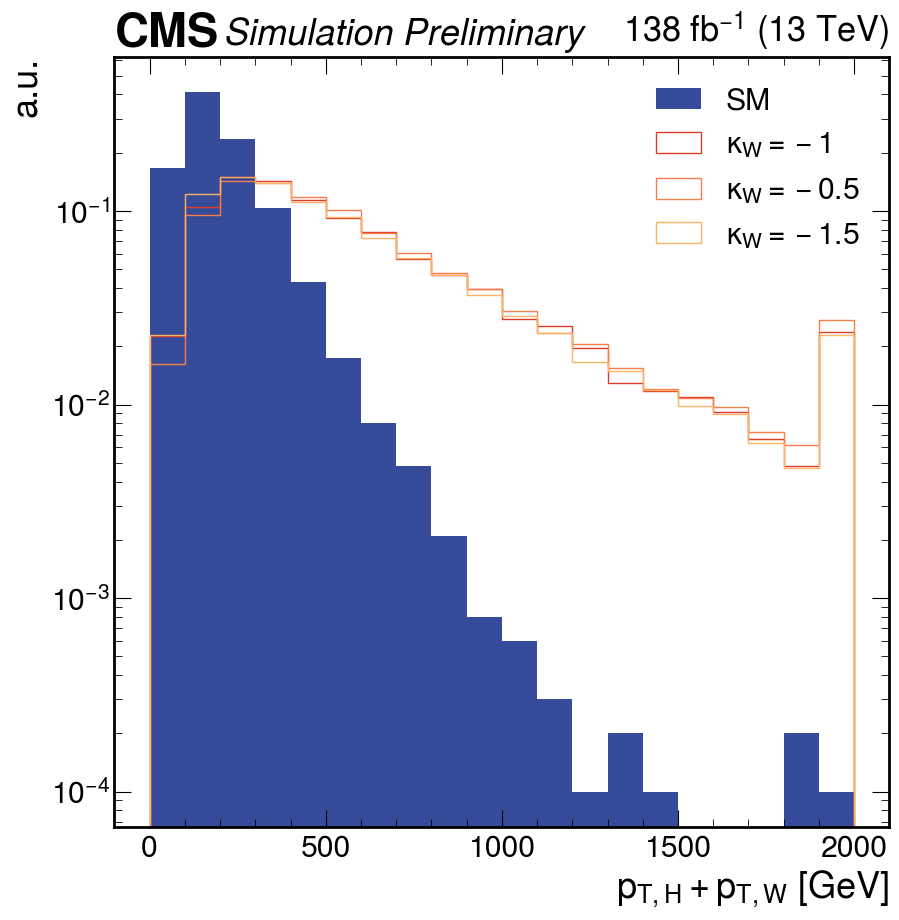

In [5]:
plot_all("ST", bins=np.linspace(0, 2000, 21), x_label="$p_{T,H} + p_{T,W}$ [GeV]", logy=True, norm=True, outfile=f"{PLOTS_DIR}/lhe_H_pt.pdf");

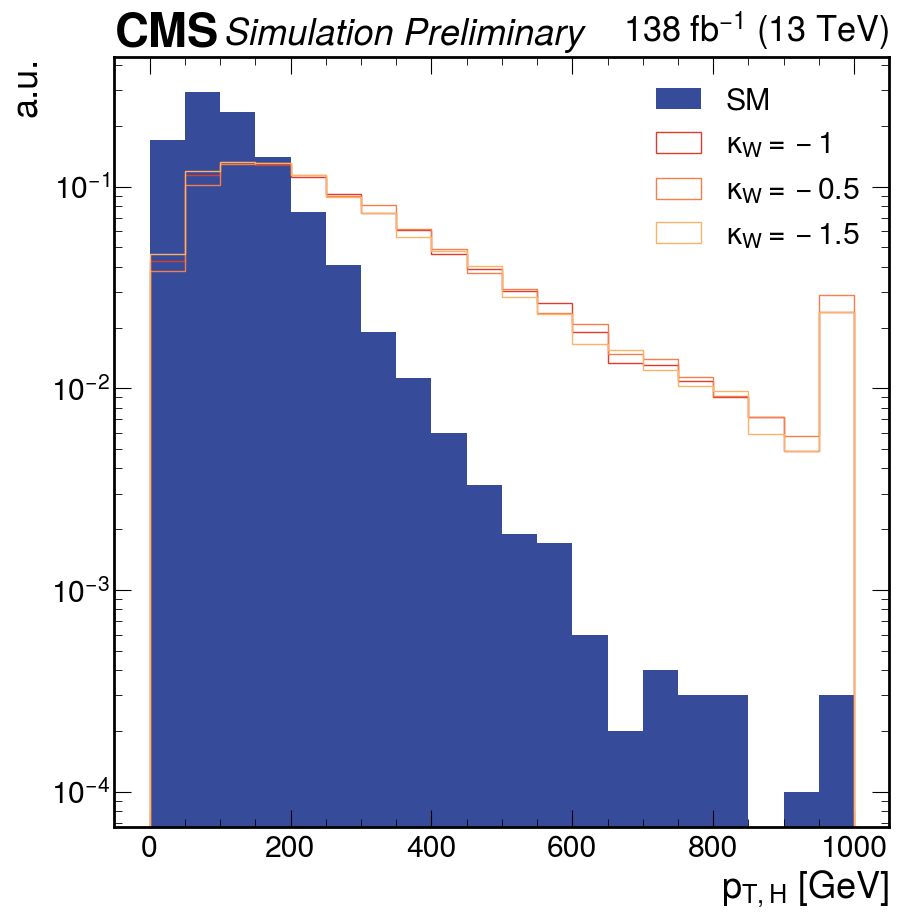

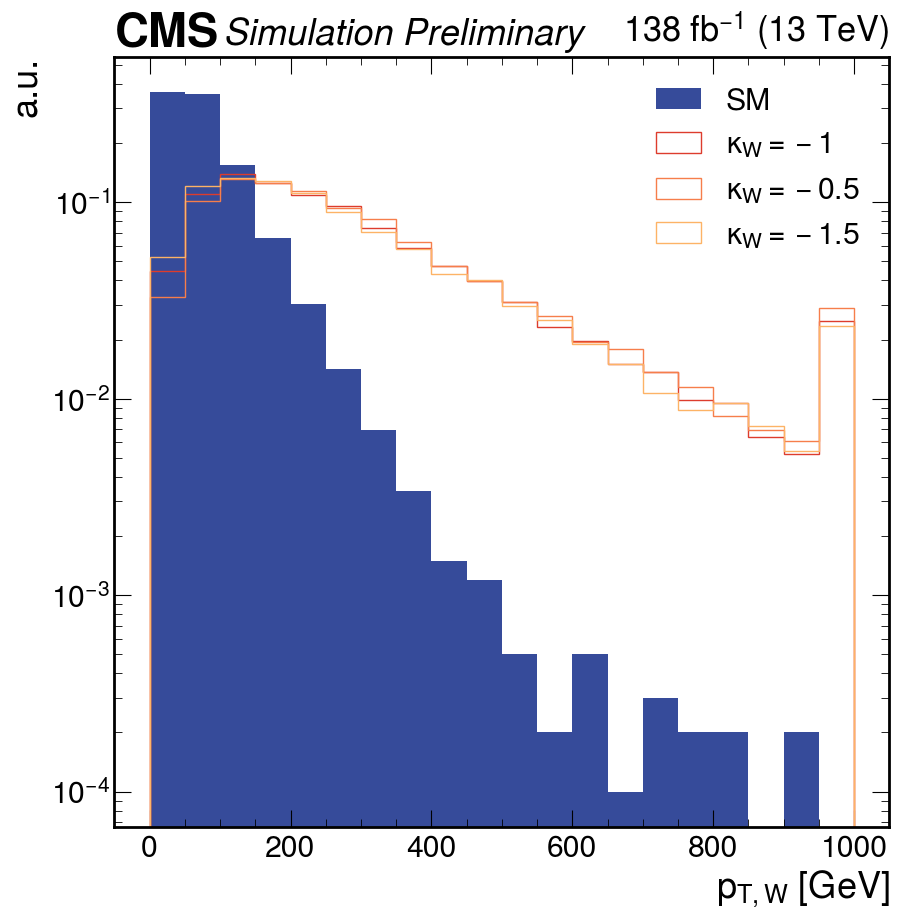

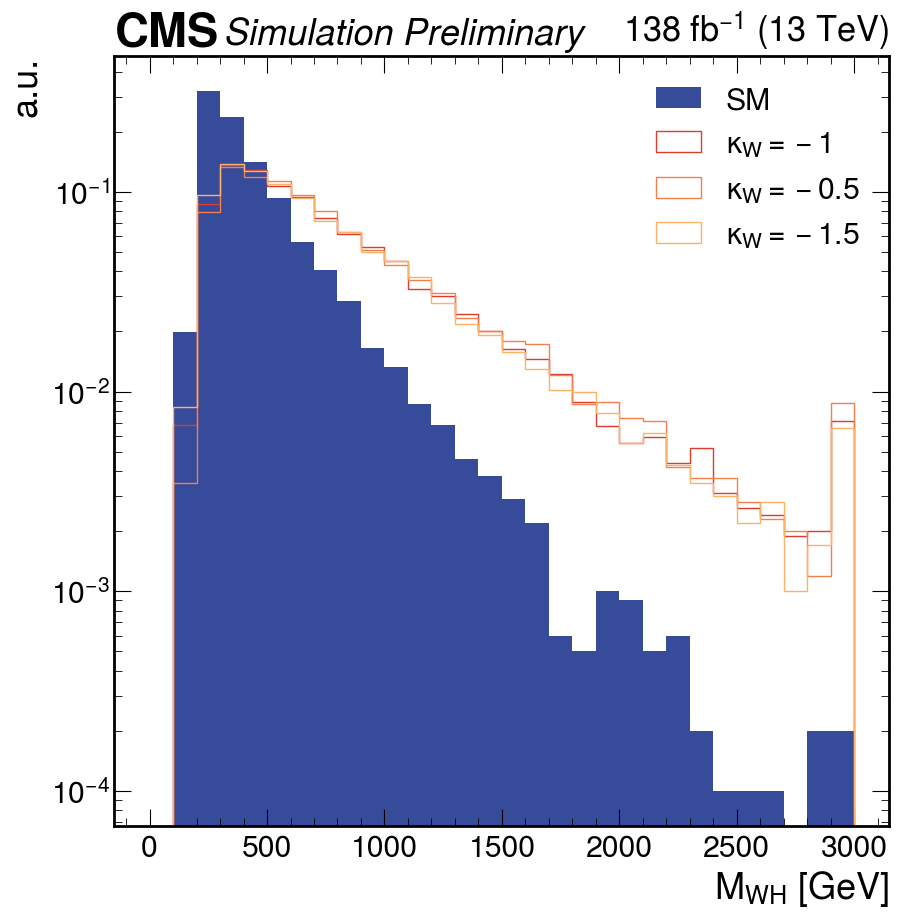

In [6]:
plot_all("H_pt", bins=np.linspace(0, 1000, 21), x_label="$p_{T,H}$ [GeV]", logy=True, norm=True, outfile=f"{PLOTS_DIR}/lhe_H_pt.pdf");
plot_all("W_pt", bins=np.linspace(0, 1000, 21), x_label="$p_{T,W}$ [GeV]", logy=True, norm=True, outfile=f"{PLOTS_DIR}/lhe_W_pt.pdf");
plot_all("M_WH", bins=np.linspace(0, 3000, 31), x_label="$M_{WH}$ [GeV]", logy=True, norm=True, outfile=f"{PLOTS_DIR}/lhe_M_WH.pdf");

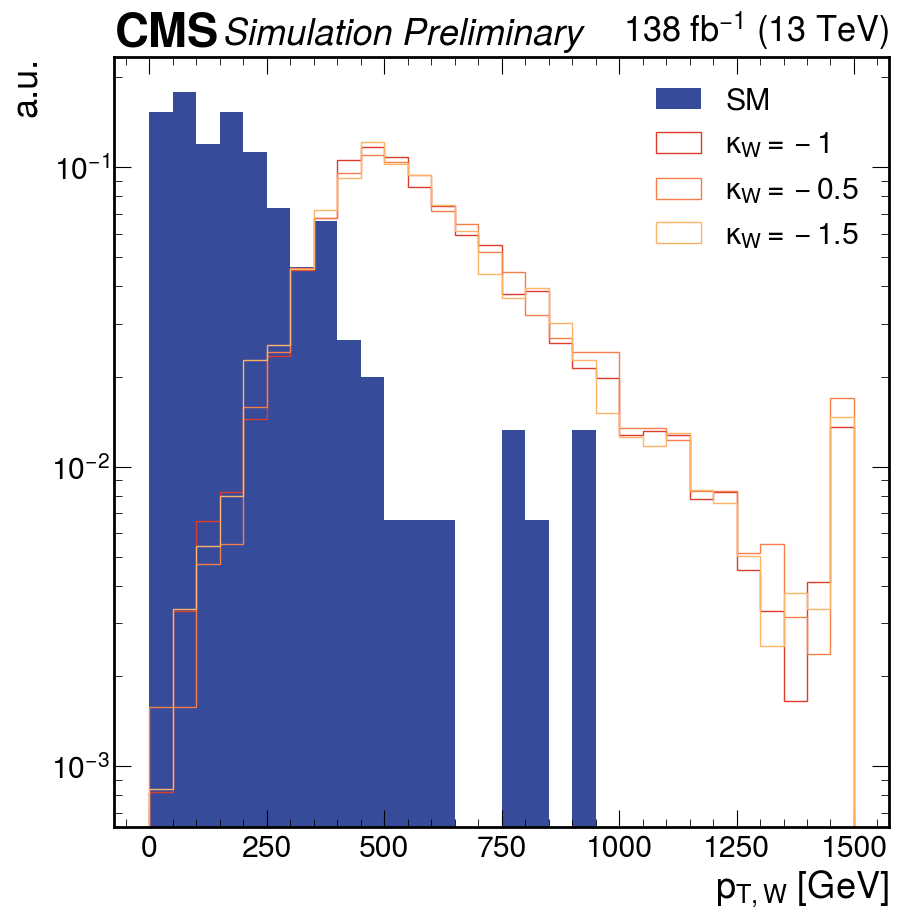

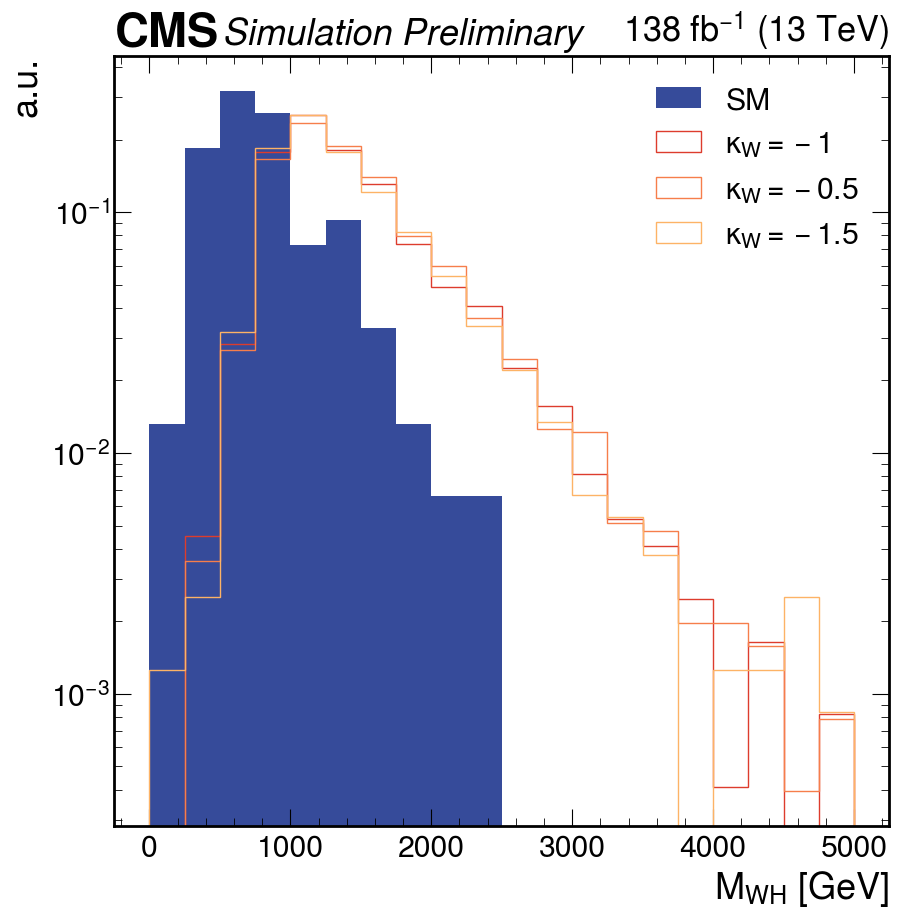

In [11]:
plot_all("W_pt", bins=np.linspace(0, 1500, 31), query="H_pt > 400", x_label="$p_{T,W}$ [GeV]", logy=True, norm=True);
plot_all("M_WH", bins=np.linspace(0, 5000, 21), query="H_pt > 400", x_label="$M_{WH}$ [GeV]", logy=True, norm=True);

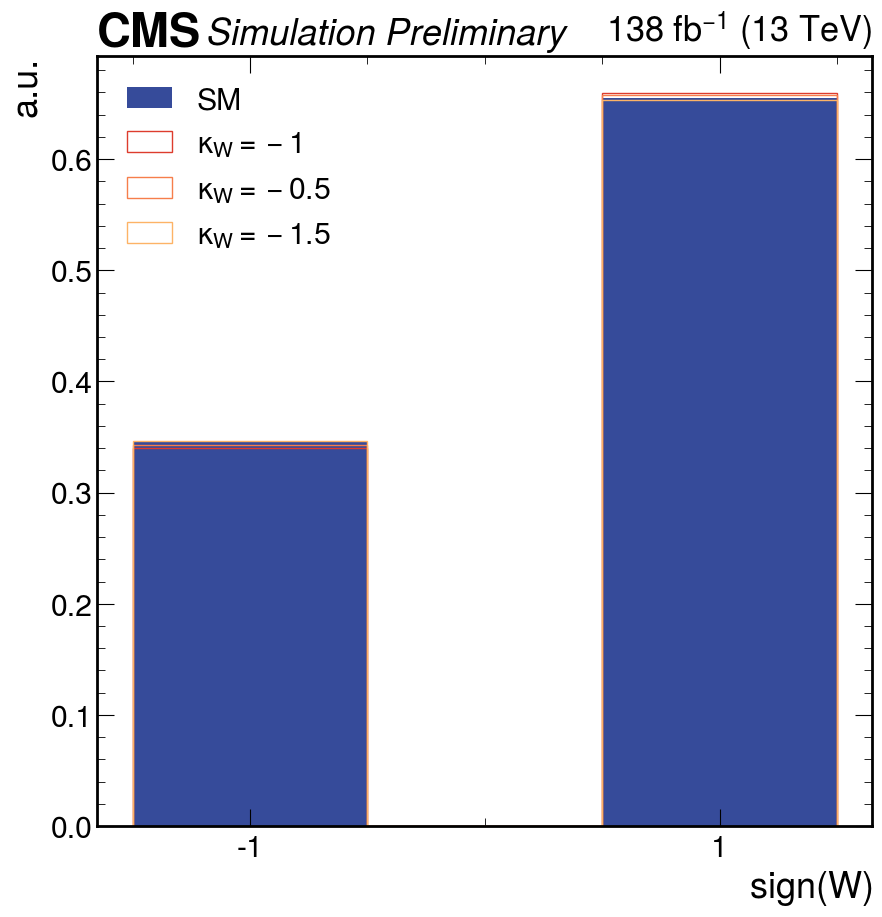

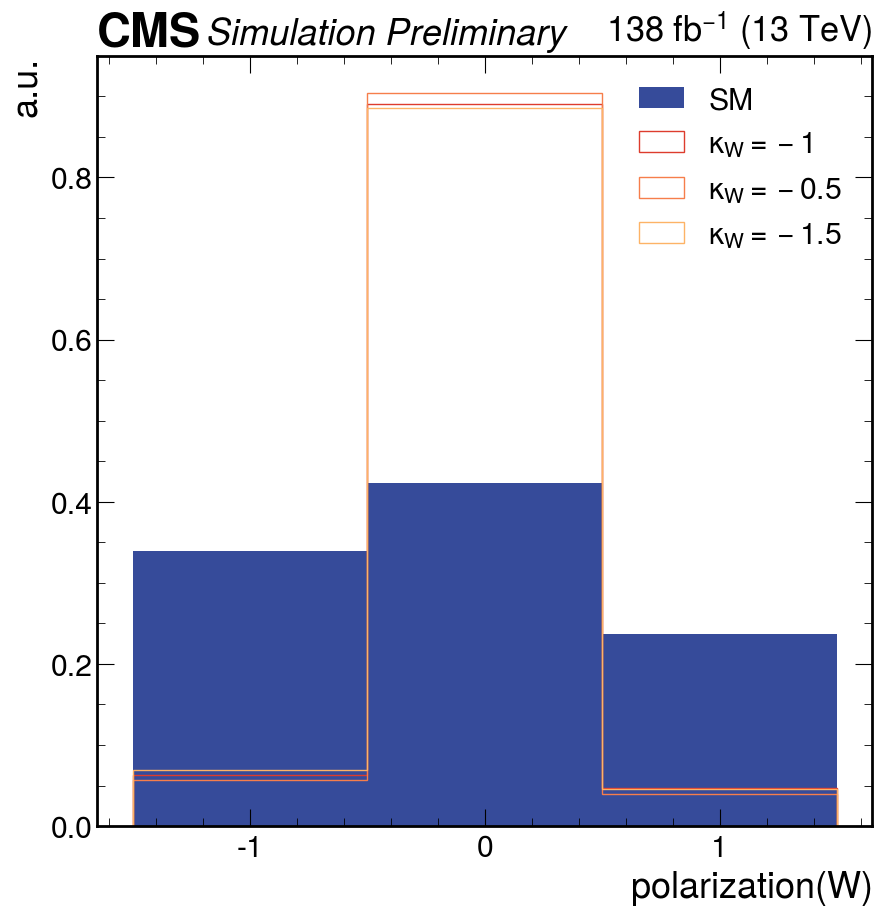

In [8]:
axes = plot_all("W_sign", bins=[-1, 0, 1, 2], x_label="$sign(W)$", transf=np.sign, norm=True)
axes.set_xticks([-0.5, 1.5]);
axes.set_xticklabels([-1, 1]);
axes.legend(loc=2);

axes = plot_all("W_pol", bins=[-1, 0, 1, 2], x_label="$polarization(W)$", transf=np.sign, norm=True)
axes.set_xticks([-0.5, 0.5, 1.5]);
axes.set_xticklabels([-1, 0, 1]);

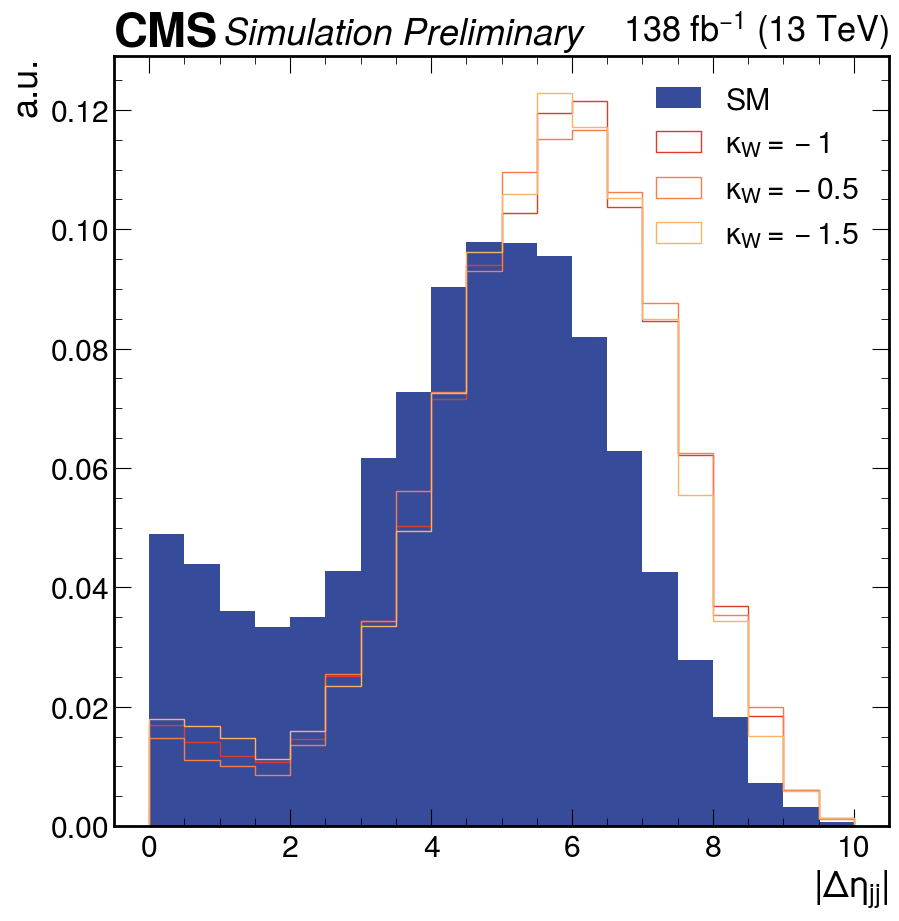

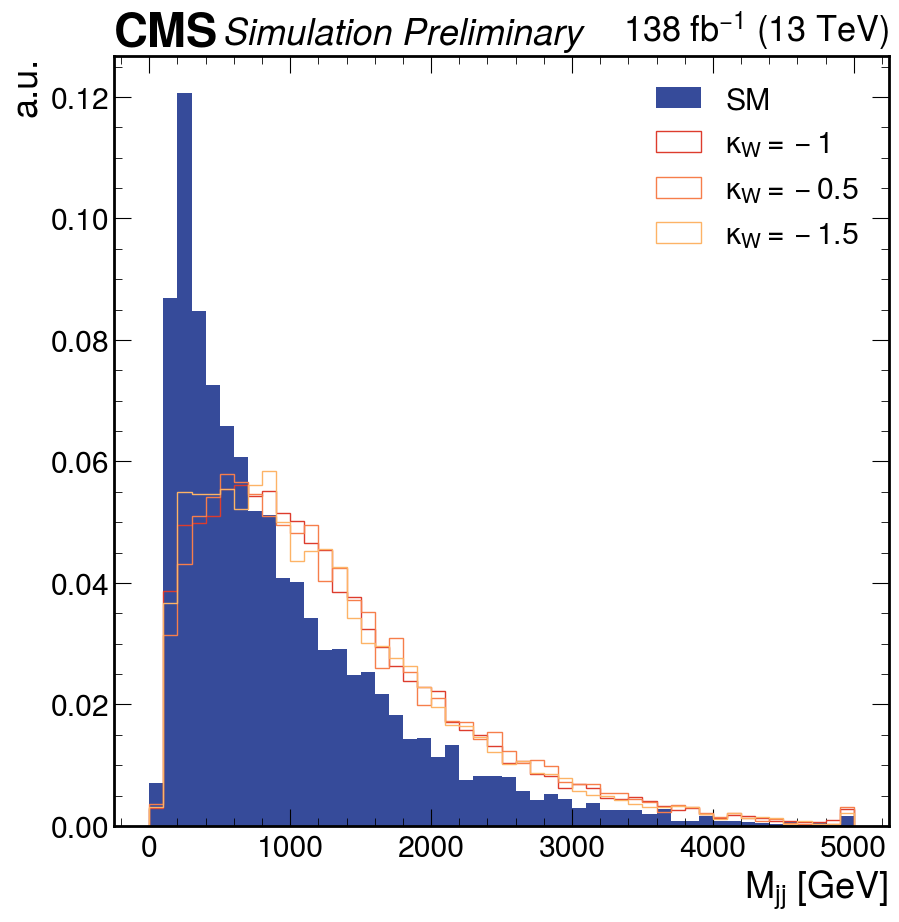

In [9]:
plot_all("deta_jj", bins=np.linspace(0, 10, 21), x_label="$|\Delta\eta_{jj}|$", transf=np.abs, norm=True);
plot_all("M_jj", bins=np.linspace(0, 5000, 51), x_label="$M_{jj}$ [GeV]", norm=True);

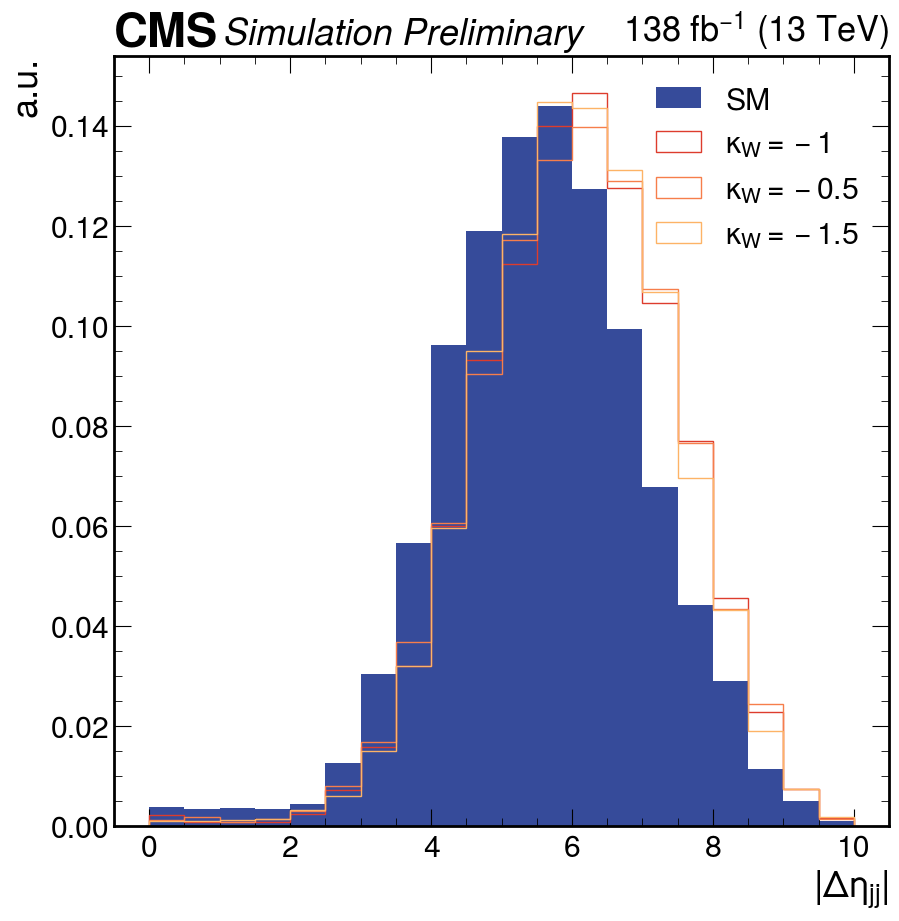

In [10]:
plot_all("deta_jj", bins=np.linspace(0, 10, 21), query="M_jj > 500", x_label="$|\Delta\eta_{jj}|$", transf=np.abs, norm=True);